Генерируем данные

(-1.5, 1.5)

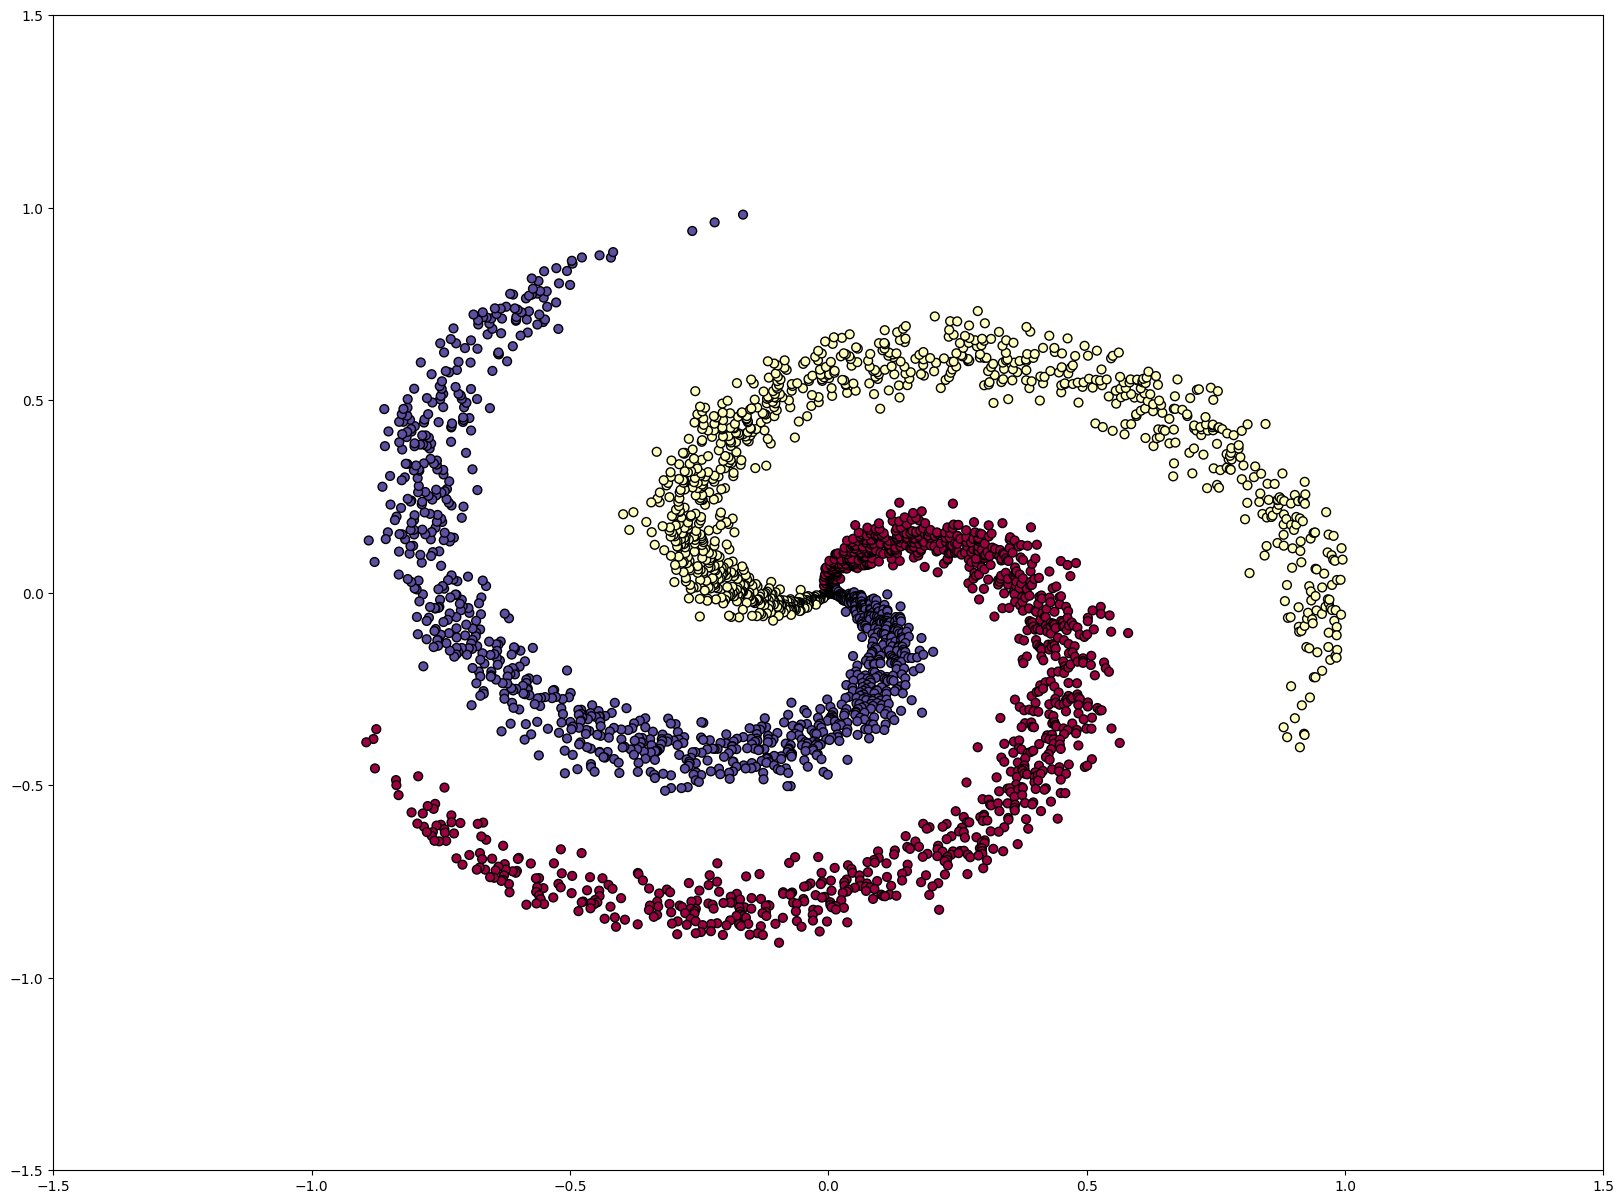

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 15.0) # задаем размер окон графиков
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

np.random.seed(0)
N = 1000 # число точек в каждом кластере
D = 2 # размерность
K = 3 # число кластеров
X = np.zeros((N*K,D))
y = np.zeros(N*K, dtype='uint8')
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # радиус
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # угол
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1], edgecolors='k', c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])
#fig.savefig('spiral_raw.png')

In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # выбираем тип вычислительного процессора

Создаем тензорный датасет и итераторы

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.30, random_state=42)

In [4]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [5]:
class SpiralDataset(Dataset):
  def __init__(self, data, targets, transform=None):
      self.data = torch.Tensor(data)
      self.targets = torch.LongTensor(targets)
      self.transform = transform
      
  def __getitem__(self, index):
      x = self.data[index]
      y = self.targets[index] 
      return x, y
  
  def __len__(self):
      return len(self.data)

In [6]:
train_dataset=SpiralDataset(X_train,y_train)
test_dataset=SpiralDataset(X_test,y_test)

In [7]:
train_dataset[0]

(tensor([ 0.4995, -0.3529]), tensor(0))

In [8]:
batch_size=50 # размер пакета
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)
dataloaders = {"train": train_loader,"validation": test_loader}

Выведем один пакет

(-1.5, 1.5)

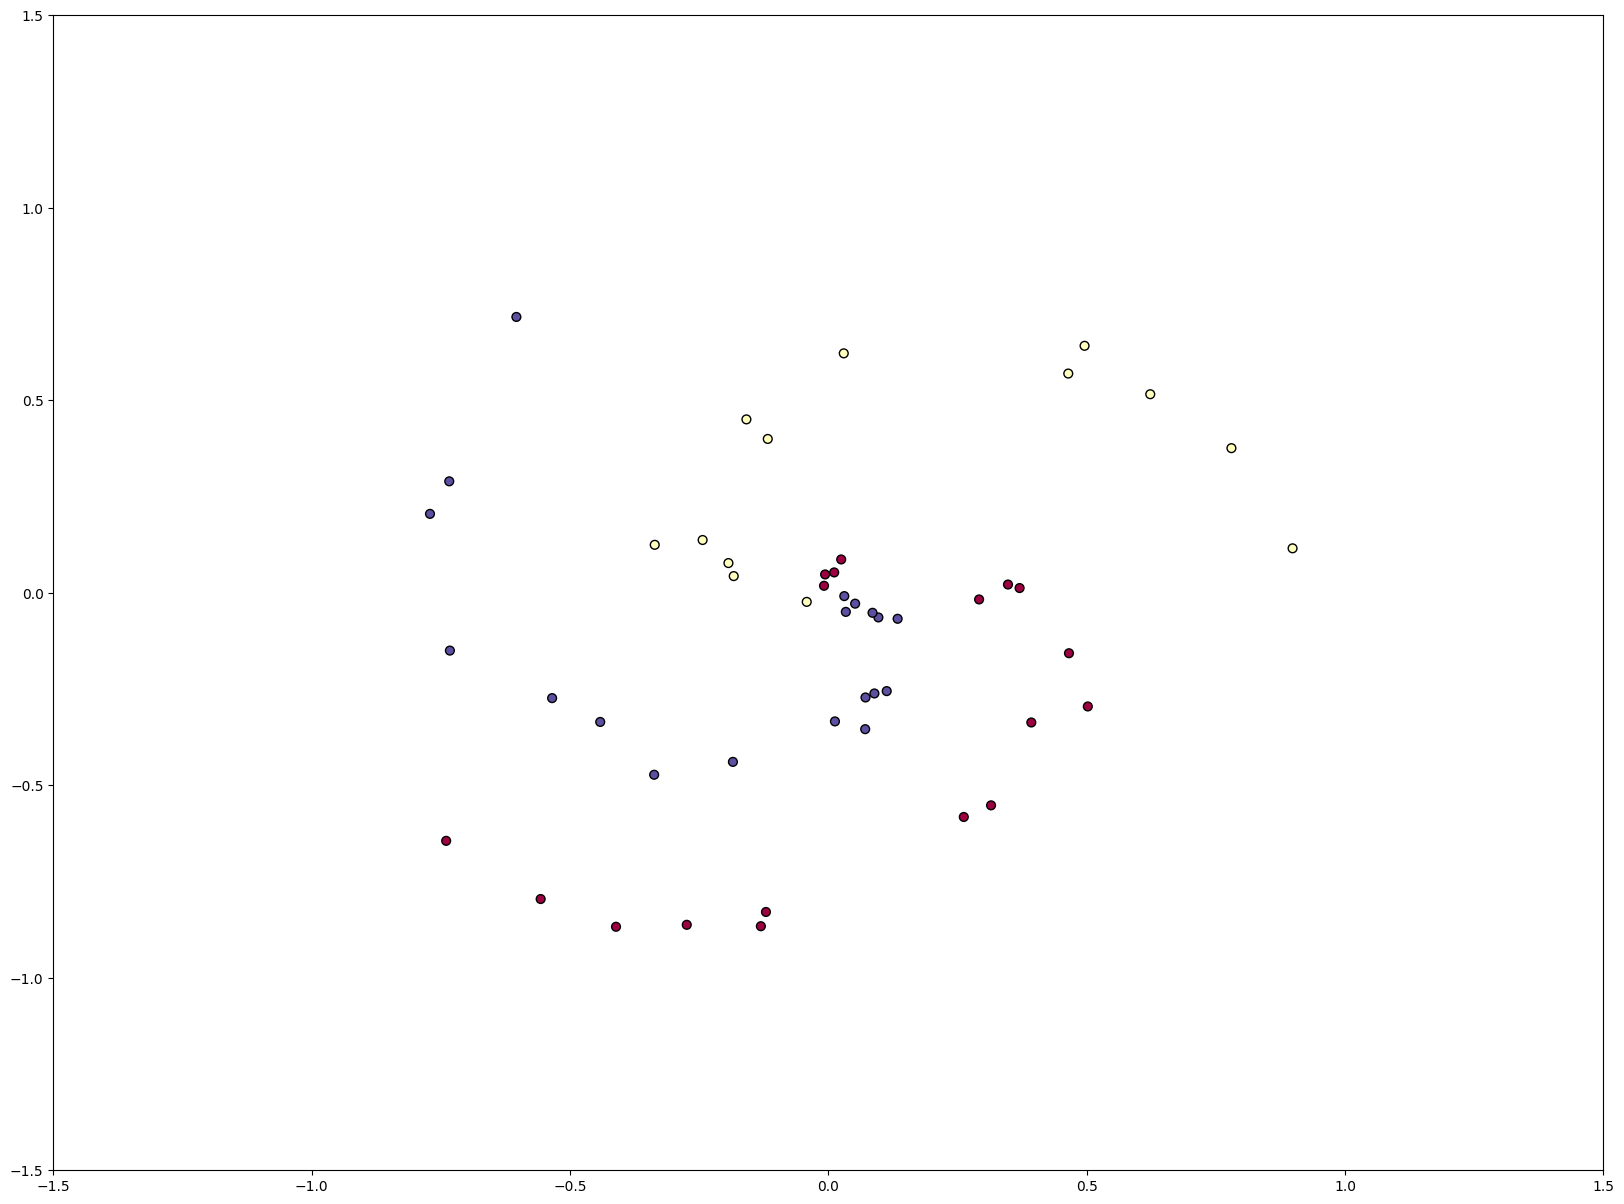

In [9]:
batch = next(iter(dataloaders['train']))
XX, yy = batch
XX=XX.to('cpu').numpy()
yy=yy.to('cpu').numpy()
fig = plt.figure()
plt.scatter(XX[:, 0], XX[:, 1], edgecolors='k', c=yy, s=40, cmap=plt.cm.Spectral)
plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])

Архитектура модели.

In [10]:
import torch.nn as nn

class Spiral_FNNN(nn.Module):
  def __init__(self, num_inputs, num_classes):
      super(Spiral_FNNN, self).__init__()
      self.pipe = nn.Sequential(
          nn.Linear(num_inputs, 25),
          nn.LeakyReLU(inplace=True),
          nn.Linear(25, 20),
          nn.LeakyReLU(inplace=True),
          nn.Linear(20, 15),
          nn.LeakyReLU(inplace=True),
          nn.Linear(15, 10),
          nn.LeakyReLU(inplace=True),
          nn.Linear(10, num_classes))
  
  def forward(self, x):
      return self.pipe(x)

In [11]:
model=Spiral_FNNN(2,7)
model.to(device)

Spiral_FNNN(
  (pipe): Sequential(
    (0): Linear(in_features=2, out_features=25, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=25, out_features=20, bias=True)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Linear(in_features=20, out_features=15, bias=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Linear(in_features=15, out_features=10, bias=True)
    (7): LeakyReLU(negative_slope=0.01, inplace=True)
    (8): Linear(in_features=10, out_features=7, bias=True)
  )
)

In [12]:
! pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
from torchinfo import summary
summary(model,input_size=(1, 2))

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
Spiral_FNNN                              [1, 7]                    --
├─Sequential: 1-1                        [1, 7]                    --
│    └─Linear: 2-1                       [1, 25]                   75
│    └─LeakyReLU: 2-2                    [1, 25]                   --
│    └─Linear: 2-3                       [1, 20]                   520
│    └─LeakyReLU: 2-4                    [1, 20]                   --
│    └─Linear: 2-5                       [1, 15]                   315
│    └─LeakyReLU: 2-6                    [1, 15]                   --
│    └─Linear: 2-7                       [1, 10]                   160
│    └─LeakyReLU: 2-8                    [1, 10]                   --
│    └─Linear: 2-9                       [1, 7]                    77
Total params: 1,147
Trainable params: 1,147
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.0

Параметры обучения

Цикл обучения.

In [14]:
! pip install livelossplot --quiet

In [15]:
from livelossplot import PlotLosses

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def train_model(model, criterion, optimizer, num_epochs=10):
  liveloss = PlotLosses()
  model = model.to(device)
  
  for epoch in range(num_epochs):
      logs = {}
      for phase in ['train', 'validation']: # две фазы: тренировочная и валидационная
          if phase == 'train':
              model.train() # режим тренировки - веса могут обновляться
          else:
              model.eval()  # режим валидации - веса заморожены

          running_loss = 0.0
          running_corrects = 0

          for inputs, labels in dataloaders[phase]:
              inputs = inputs.to(device)
              labels = labels.to(device)

              outputs = model(inputs) # прямой проход модели
              loss = criterion(outputs, labels) # ошибка пакета

              if phase == 'train':
                  optimizer.zero_grad() # обнуляем градиенты
                  loss.backward()  # обратное распространение ошибки
                  optimizer.step() # обновление весов алгоритмом оптимизации

              _, preds = torch.max(outputs, 1) 
              running_loss += loss.detach() * inputs.size(0)
              running_corrects += torch.sum(preds == labels.data)

          epoch_loss = running_loss / len(dataloaders[phase].dataset)
          epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)
          
          prefix = ''
          if phase == 'validation':
              prefix = 'val_'

          logs[prefix + 'log loss'] = epoch_loss.item()
          logs[prefix + 'accuracy'] = epoch_acc.item()
      
      liveloss.update(logs)
      liveloss.send()

Запуск цикла обучения

In [16]:
from torch import optim
model=Spiral_FNNN(2,7)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

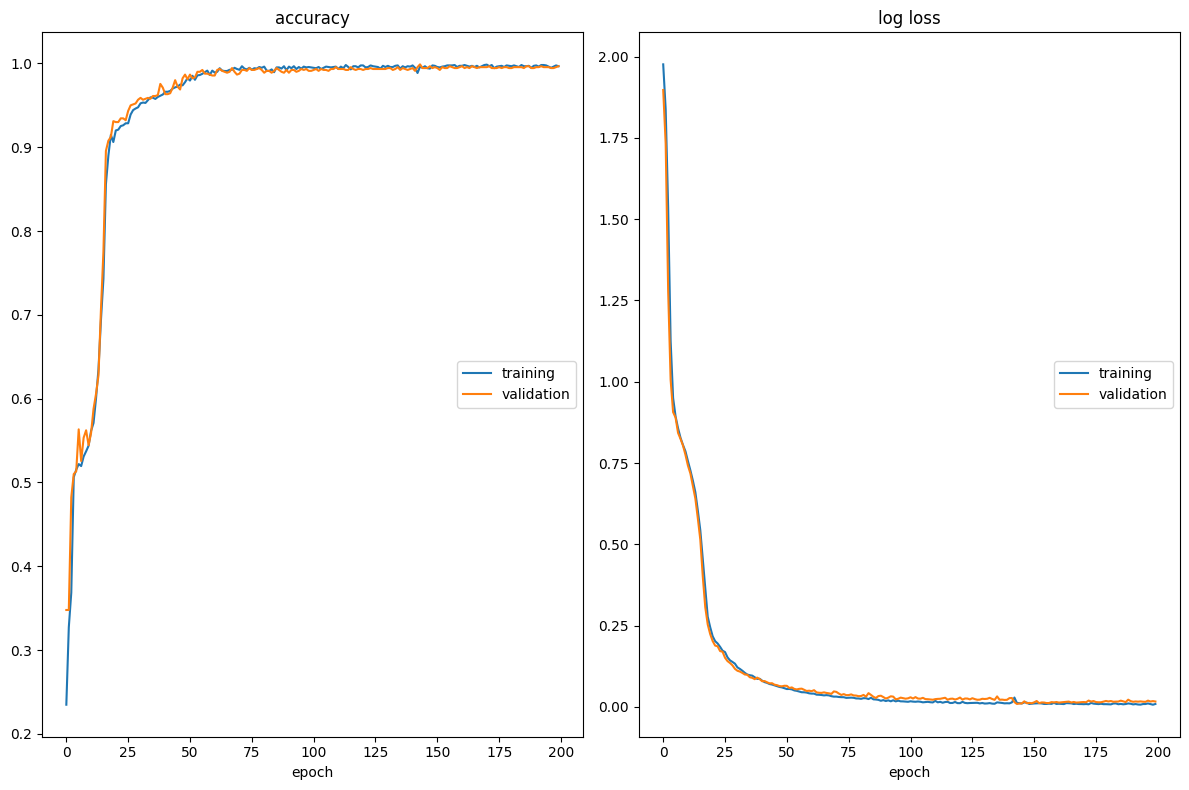

accuracy
	training         	 (min:    0.235, max:    0.999, cur:    0.997)
	validation       	 (min:    0.348, max:    0.999, cur:    0.997)
log loss
	training         	 (min:    0.007, max:    1.976, cur:    0.009)
	validation       	 (min:    0.009, max:    1.897, cur:    0.017)


In [17]:
train_model(model, criterion, optimizer, num_epochs=200)

Нарисуем разделяющую поверхность.

In [18]:
def plot_decision_boundary(network, features, labels):
  # Рисуем разделяющие поверхности
  x_min, x_max = features[:, 0].min()-1, features[:, 0].max()+1
  y_min, y_max = features[:, 1].min()-1, features[:, 1].max()+1

  spacing = min(x_max - x_min, y_max - y_min) / 250

  XX, YY = np.meshgrid(np.arange(x_min, x_max, spacing),
               np.arange(y_min, y_max, spacing))

  data = np.hstack((XX.ravel().reshape(-1,1), 
                  YY.ravel().reshape(-1,1)))

  data_t = torch.tensor(data, dtype=torch.float).to(device)
  model.eval()
  Z = model(data_t)

  #Переводим torch-тензор в numpy, чтобы нарисовать график .
  Z = np.argmax(Z.detach().cpu().numpy(), axis=1)
  Z = Z.reshape(XX.shape)
  fig = plt.figure()
  plt.contourf(XX, YY, Z, cmap=plt.cm.Spectral, alpha=0.8)
  plt.scatter(features[:, 0], features[:, 1], edgecolors='k', c=labels, s=40, cmap=plt.cm.Spectral)
  plt.xlim(XX.min(), XX.max())
  plt.ylim(YY.min(), YY.max())
  #fig.savefig('spiral_linear.png')
  plt.show()

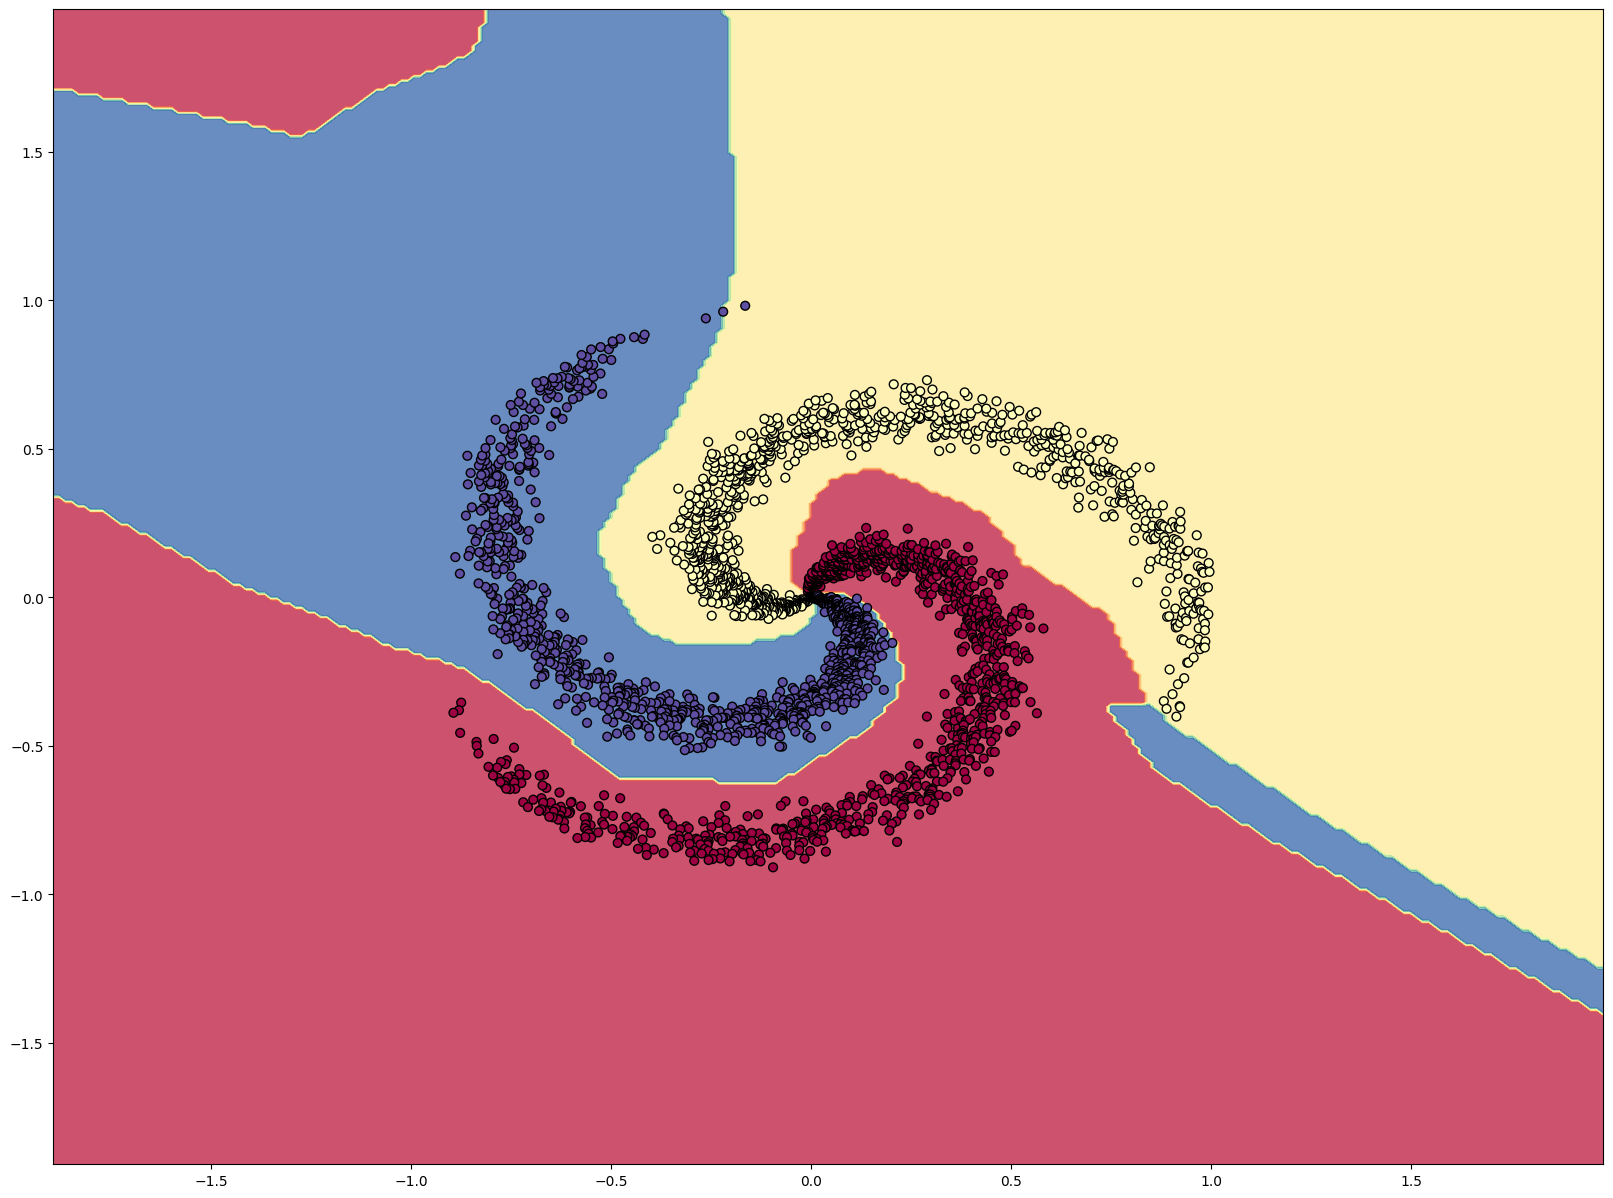

In [19]:
plot_decision_boundary(model, X, y)